# Text2Image Example using Hugging Face library on CUDA 

## Creating the Environment for this Notebook
#### Option 1 create Environment using micromaba
```
micromamba create -n gpuTutorialEnv -c conda-forge -c nvidia -c pytorch -y  pytorch-cuda=11.8 pytorch jupyterlab diffusers transformers accelerate safetensors omegaconf ipywidgets 
```

#### Option 2 load exiwsting Environment via Terrabyte OpenOnDemand Portal
```
specify "/dss/dsstbyfs01/pn56su/pn56su-dss-0020/opt/micromamba/envs/terrabyte_gpu" as a custom Jupyterlab micormaba Environment on the OpenOnDemand Portal 
```


### Make sure a GPU is available and torch utilizes it 
If nvidia-smi is not found a GPU is most likely not available
if Torch is not CUDA enabled, try (re)installing it in the cuda enabled version (not cpu)

In [1]:
!nvidia-smi

Thu Nov 16 17:45:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:4B:00.0 Off |                    0 |
| N/A   43C    P0    66W / 500W |      0MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
print("Torch version:",torch.__version__)

print("Is CUDA enabled?",torch.cuda.is_available())
#If Cuda is not enabled recheck and reinstall pytorch in GPU Version

Torch version: 2.1.0.post300
Is CUDA enabled? True


## Hugging Face Text2Image
URL: "https://huggingface.co/docs/diffusers/quicktour"

### Simple stable diffusion pipeline 

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

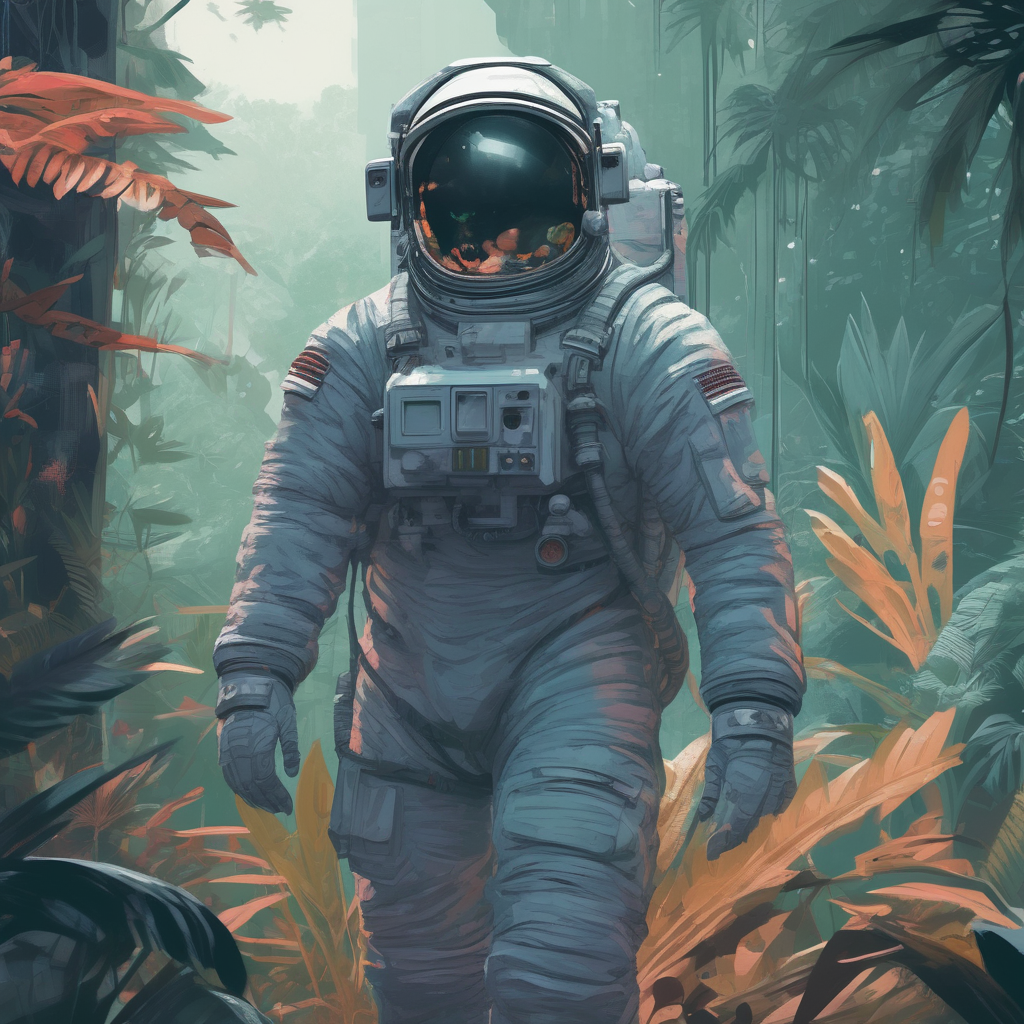

In [4]:
from diffusers import AutoPipelineForText2Image, StableDiffusionXLPipeline, StableDiffusionXLImg2ImgPipeline
import torch

pipeline_text2image = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
).to("cuda")

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
image = pipeline_text2image(prompt=prompt).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

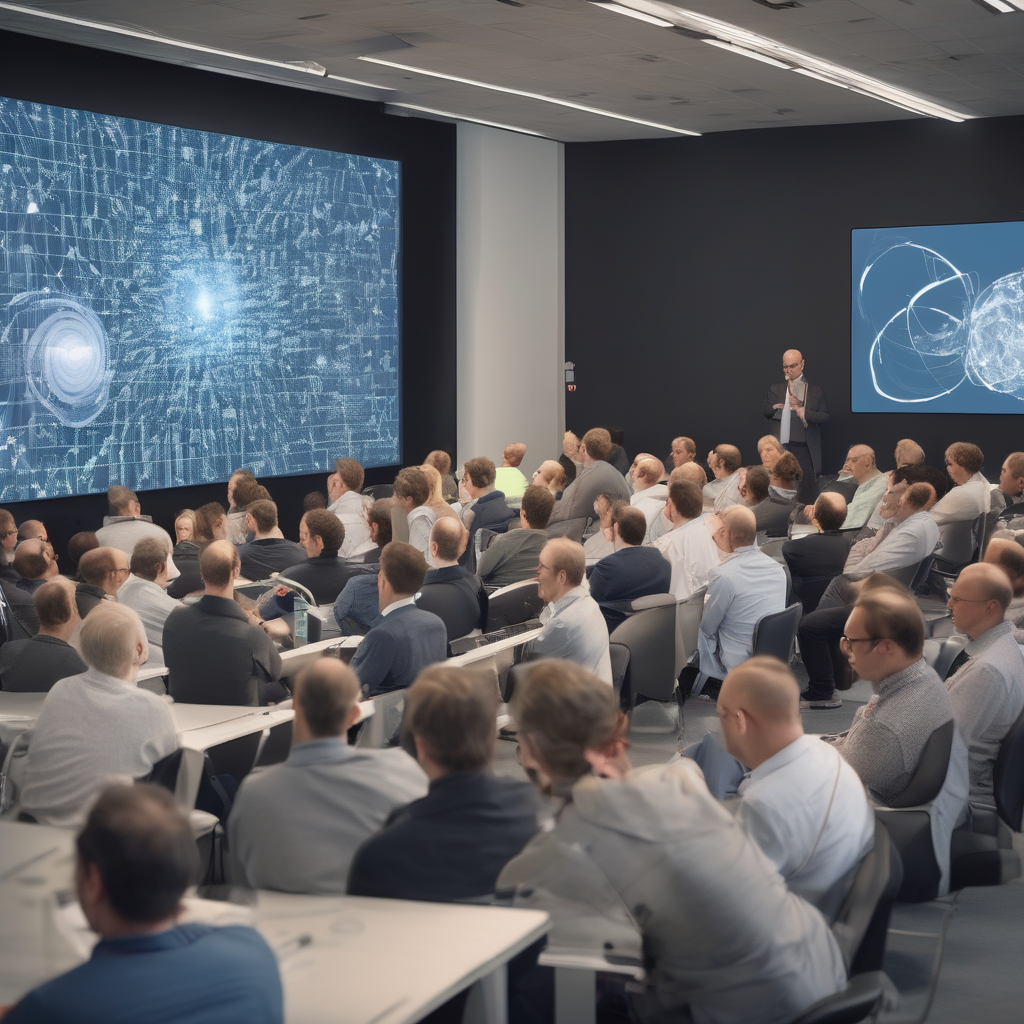

In [5]:
prompt = "25 scientists sitting at the german airospace center listening to a talk about machine learning, photorealistic, detailed, 8k"

image = pipeline_text2image(prompt=prompt).images[0]
image

### Enhance Image Quality with a refiner

In [6]:
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image
from diffusers import DiffusionPipeline
import torch

base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
).to("cuda")

refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

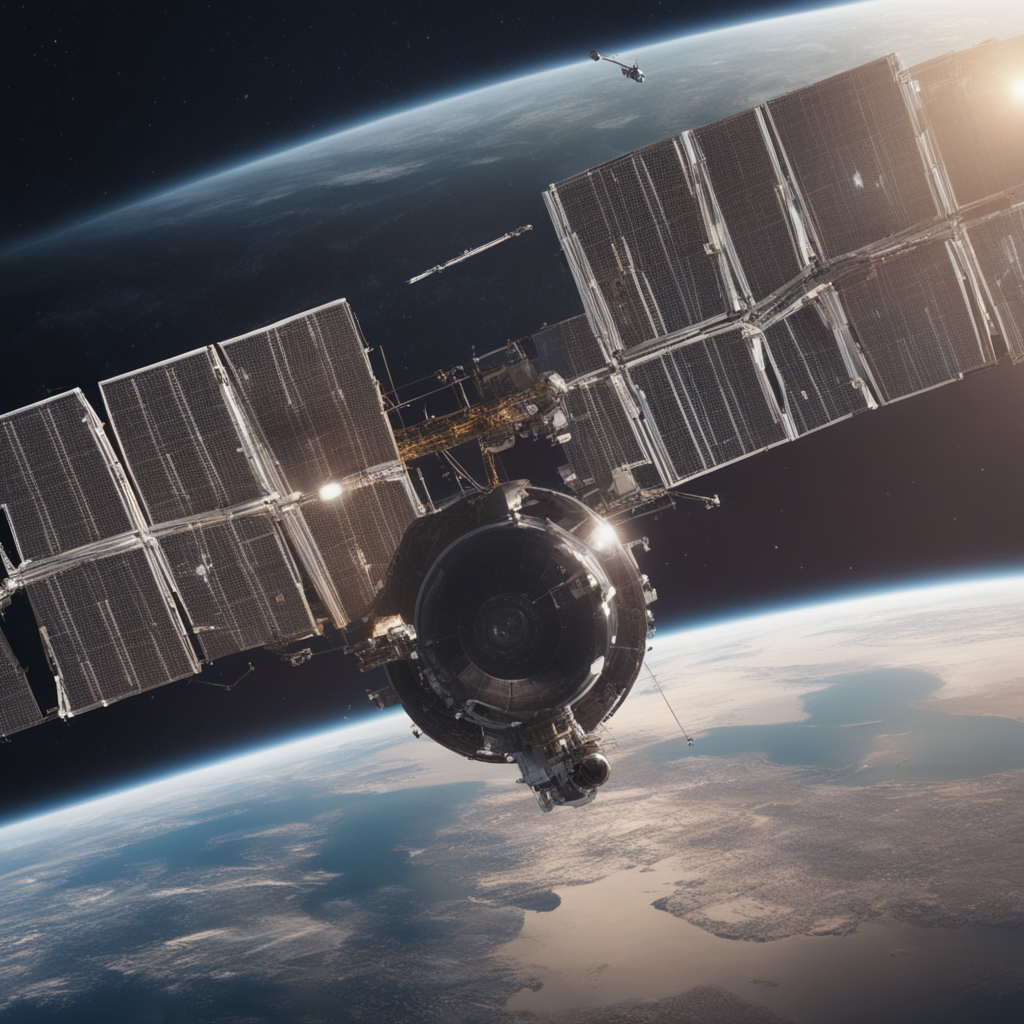

In [7]:
prompt = "A Satellite orbiting the Earth, photorealistic 8k"

image = base(
    prompt=prompt,
    num_inference_steps=40,
    denoising_end=0.8,
    output_type="latent",
).images

image = refiner(
    prompt=prompt,
    num_inference_steps=40,
    denoising_start=0.8,
    image=image,
).images[0]
image